In [146]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = False

In [91]:
data = pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv', header=0, index_col=0)

In [92]:
data.head()

,Present Storage(TMC),Reservoir Level(TMC),Inflow,Outflow,MADIKERI,SOMWARPET,VIRAJPET
Dates,,,,,,,
2011-01-01,3.74,2835.90,142.0,0.0,0.0,0.0,0.0
2011-01-02,3.76,2836.09,239.0,0.0,0.0,0.0,0.0
2011-01-03,3.77,2836.22,166.0,0.0,0.0,0.0,0.0
2011-01-04,3.78,2836.31,118.0,0.0,0.0,0.0,0.0
2011-01-05,3.79,2836.41,130.0,0.0,0.0,0.0,0.0


In [93]:

# load data
# def parse(x):
# 	return datetime.strptime(x, '%Y %m %d %H')
# dataset = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
# dataset.drop('No', axis=1, inplace=True)
# # manually specify column names
data=data.drop(columns = ['Present Storage(TMC)', 'Reservoir Level(TMC)', 'Outflow'])
#data.index.name = 'date'
# # mark all NA values with 0
# dataset['pollution'].fillna(0, inplace=True)
# # drop the first 24 hours
# dataset = dataset[24:]
# summarize first 5 rows
print(data.head(5))
# save to file
# dataset.to_csv('pollution.csv')

            Inflow  MADIKERI  SOMWARPET  VIRAJPET
Dates                                            
2011-01-01   142.0       0.0        0.0       0.0
2011-01-02   239.0       0.0        0.0       0.0
2011-01-03   166.0       0.0        0.0       0.0
2011-01-04   118.0       0.0        0.0       0.0
2011-01-05   130.0       0.0        0.0       0.0


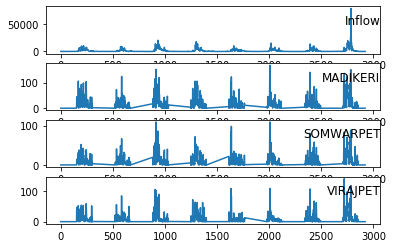

In [94]:
# load dataset
dataset = data#pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [131]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
# dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 6, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),...,var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
6,0.001823,0.0,0.0,0.0,0.003068,0.0,0.0,0.0,0.002131,0.0,...,0.0,0.0,0.002144,0.0,0.0,0.0,0.001913,0.0,0.0,0.0
7,0.003068,0.0,0.0,0.0,0.002131,0.0,0.0,0.0,0.001515,0.0,...,0.0,0.0,0.001913,0.0,0.0,0.0,0.001682,0.0,0.0,0.0
8,0.002131,0.0,0.0,0.0,0.001515,0.0,0.0,0.0,0.001669,0.0,...,0.0,0.0,0.001682,0.0,0.0,0.0,0.001438,0.0,0.0,0.0
9,0.001515,0.0,0.0,0.0,0.001669,0.0,0.0,0.0,0.002144,0.0,...,0.0,0.0,0.001438,0.0,0.0,0.0,0.002054,0.0,0.0,0.0
10,0.001669,0.0,0.0,0.0,0.002144,0.0,0.0,0.0,0.001913,0.0,...,0.0,0.0,0.002054,0.0,0.0,0.0,0.002208,0.0,0.0,0.0


In [151]:
values = reframed.values
n_hours = 6
n_features = 4
n_train_days = 365 * 3
train = values[:n_train_days, :]
test = values[n_train_days:, :]
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1095, 24) 1095 (1095,)
(1095, 6, 4) (1095,) (1821, 6, 4) (1821,)


Train on 1095 samples, validate on 1821 samples
Epoch 1/50
 - 0s - loss: 0.0152 - val_loss: 0.0169
Epoch 2/50
 - 0s - loss: 0.0140 - val_loss: 0.0125
Epoch 3/50
 - 0s - loss: 0.0113 - val_loss: 0.0115
Epoch 4/50
 - 0s - loss: 0.0087 - val_loss: 0.0120
Epoch 5/50
 - 0s - loss: 0.0103 - val_loss: 0.0098
Epoch 6/50
 - 0s - loss: 0.0070 - val_loss: 0.0118
Epoch 7/50
 - 0s - loss: 0.0080 - val_loss: 0.0115
Epoch 8/50
 - 0s - loss: 0.0081 - val_loss: 0.0094
Epoch 9/50
 - 0s - loss: 0.0068 - val_loss: 0.0127
Epoch 10/50
 - 0s - loss: 0.0067 - val_loss: 0.0081
Epoch 11/50
 - 0s - loss: 0.0053 - val_loss: 0.0078
Epoch 12/50
 - 0s - loss: 0.0060 - val_loss: 0.0082
Epoch 13/50
 - 0s - loss: 0.0059 - val_loss: 0.0076
Epoch 14/50
 - 0s - loss: 0.0064 - val_loss: 0.0101
Epoch 15/50
 - 0s - loss: 0.0067 - val_loss: 0.0114
Epoch 16/50
 - 0s - loss: 0.0071 - val_loss: 0.0090
Epoch 17/50
 - 0s - loss: 0.0064 - val_loss: 0.0074
Epoch 18/50
 - 0s - loss: 0.0059 - val_loss: 0.0092
Epoch 19/50
 - 0s - loss:

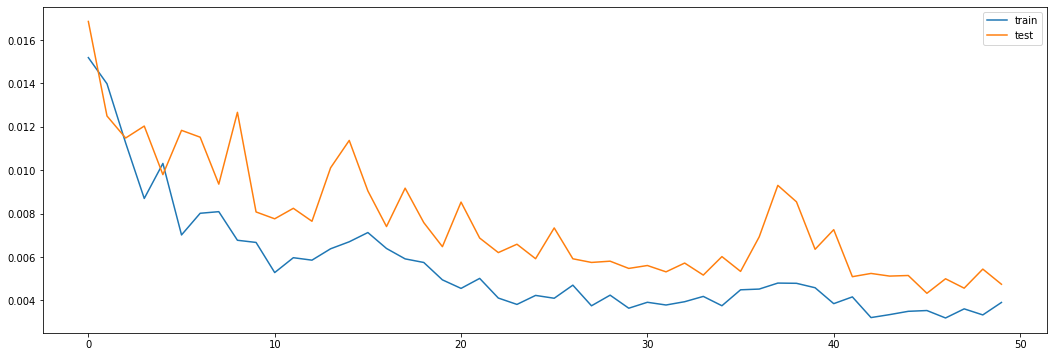

In [152]:
model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=70, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [153]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 952.268


In [79]:
inv_yhat.shape

(1094,)

In [89]:
import math
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 198.510


In [115]:
te=test_y.reshape((test_y.shape[0]))
# yhat = model.predict(test_X)

In [106]:
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

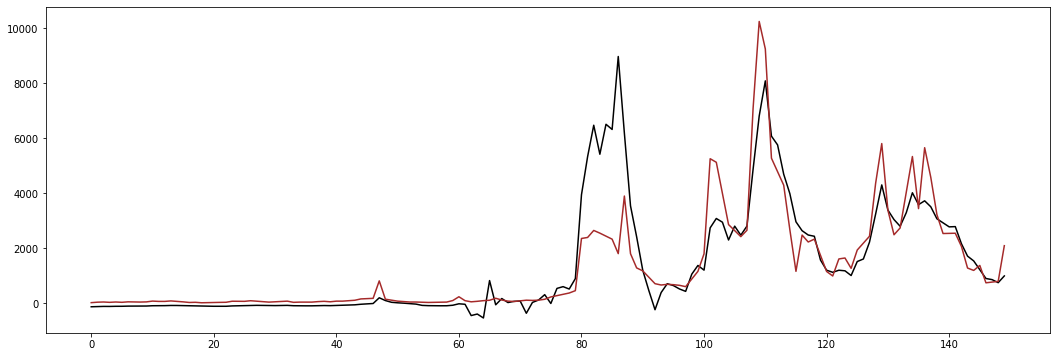

In [164]:
pyplot.plot(inv_yhat[450:600],c='black')
pyplot.plot(inv_y[450:600],c='brown')
pyplot.show()

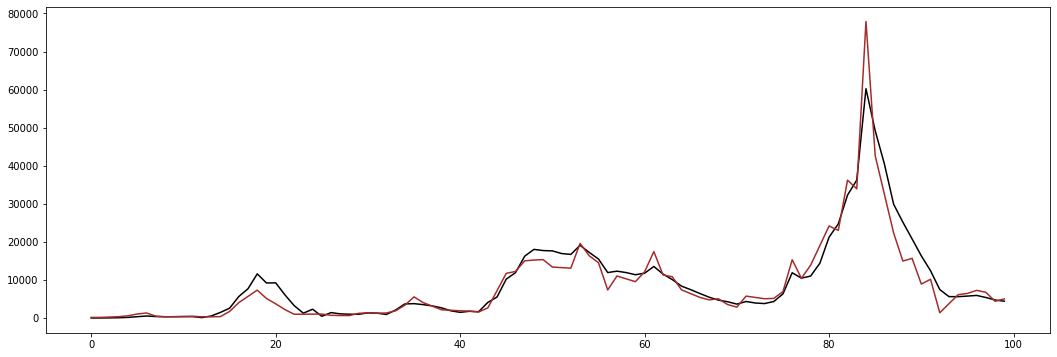

In [167]:
pyplot.plot(inv_yhat[1600:1700],c='black')
pyplot.plot(inv_y[1600:1700],c='brown')
pyplot.show()

In [119]:
scaler.inverse_transform(te)

ValueError: Expected 2D array, got 1D array instead:
array=[0.06011012 0.05985964 0.05960917 ... 0.         0.         0.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [120]:
scale = MinMaxScaler(feature_range=(0, 1))
scal = scale.fit_transform(data.Inflow)

ValueError: Expected 2D array, got 1D array instead:
array=[142. 239. 166. ... 102.  99.  99.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.